In [1]:
import numpy as np
import pylab as plt
from ant_array import RadioArray
from astropy.time import Time
import ephem
import h5py

import hickle as hkl
import dask
from dask.distributed import Client, progress
client = Client(n_workers=7, threads_per_worker=1)

distributed.diskutils - INFO - Found stale lock file and directory '/Users/dancpr/Data/blink/dask-worker-space/worker-o574k7yh', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/dancpr/Data/blink/dask-worker-space/worker-ot6j5tqt', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/dancpr/Data/blink/dask-worker-space/worker-1zgjciqw', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/dancpr/Data/blink/dask-worker-space/worker-g3f16ajz', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/dancpr/Data/blink/dask-worker-space/worker-hr5cq72s', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/dancpr/Data/blink/dask-worker-space/worker-jvghvbce', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/dancpr/Data/blink/dask-worker-space/worker-kp_j95az', purging
distributed.diskutils - INFO - Found stal

In [3]:
filename_data = 'test-data/eda2/20200209/chan_204_20200209T034646_vis_real.fits'
filename_ant  = 'eda_antenna_locations_v2.h5'
# Setup array
f_mhz = np.array([159.3750])
lat = '-26:42:11:95'
lon = '116:40:14.93'
elev = 500
t = Time('2020-02-09T03:46:46.0', format='isot')
sun = ephem.Sun()

# Initialize EDA array
eda = RadioArray(lat, lon, elev, f_mhz, filename_ant, t0=t.datetime, verbose=True, phase_center=sun)
eda.load_fits_data(filename_data)
#eda.date = t.datetime
#eda.update(t.datetime)

Time: 2020/2/9 03:46:46
Sun 	RA / DEC:  (21:29:01.23, -14:51:39.7) 
	ALT / AZ:  (74:49:40.3, 40:43:47.7)
ZENITH: (20:47:08.87, -26:46:33.5)
HA, D: (-0.18270382264997043, -14:51:39.7)
Applying phase delay matrix


/Users/dancpr/Data/blink/ant_array.py:345: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(img), extent=(-1, 1, 1, -1), interpolation='none')
/Users/dancpr/Data/blink/ant_array.py:345: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(img), extent=(-1, 1, 1, -1), interpolation='none')


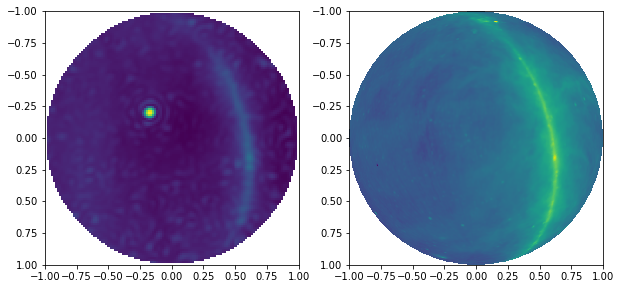

In [3]:
pmap = eda.generate_gsm()
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
eda.plot_image()

plt.subplot(1,2,2)
eda.plot_image(pmap)

### HDF5 dataset

In [4]:
h5_path = '/Volumes/JIDIJIDI/astro-data/corr_mat_chunked_2020.05.20.h5'
h5_metadata_path = '/Volumes/JIDIJIDI/astro-data/corr_mat_metadata_v4_2020.05.20.h5'

md = h5py.File(h5_metadata_path, 'r')
f_mhz = md['freqs'][:]
t = Time(md['time'], format='jd')

sun = ephem.Sun()
eda = RadioArray(lat, lon, elev, f_mhz, filename_ant, t0=t[0].datetime, verbose=True, 
                 phase_center=sun, conjugate_data=True)
eda.load_h5_data(h5_path)

Time: 2020/5/20 03:43:36
Sun 	RA / DEC:  (3:49:35.59, 20:03:48.4) 
	ALT / AZ:  (42:49:07.8, 8:25:04.5)
ZENITH: (3:22:30.09, -26:46:24.0)
HA, D: (-0.11820953279782864, 20:03:48.4)
Updating freq idx
Updating phase matrix
Time: 2020/5/20 03:43:36
Sun 	RA / DEC:  (3:49:35.59, 20:03:48.4) 
	ALT / AZ:  (42:49:07.8, 8:25:04.5)
ZENITH: (3:22:30.09, -26:46:24.0)
HA, D: (-0.11820953279782864, 20:03:48.4)
conjugating data
Applying phase delay matrix


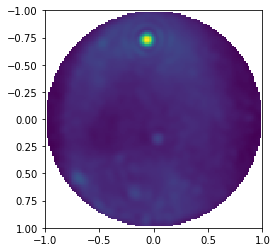

In [19]:
f_idx = 1000
eda.verbose = False
eda.update(date=t[f_idx // 32].datetime, f_idx=f_idx, pol_idx=0)
eda.plot_image()

In [5]:
def run_imager(f_mhz, t, f_idxs):
    h5_path       = '/Volumes/JIDIJIDI/astro-data/corr_mat_chunked_2020.05.20.h5'
    filename_ant  = 'eda_antenna_locations_v2.h5'
    lat = '-26:42:11:95'
    lon = '116:40:14.93'
    elev = 500
    n_pix = 129
    sun = ephem.Sun()
    eda = RadioArray(lat, lon, elev, f_mhz, filename_ant, t0=t[0].datetime, verbose=False, 
                     phase_center=sun, conjugate_data=True)
    eda.load_h5_data(h5_path)
    hkl.dump(f_idxs, f'dask-out/freqs-{f_idxs[0]}.hkl')
    for f_idx in f_idxs:
        for p_idx in (0,1,2,3):
            #print(f"generating F {f_idx} P {p_idx}")
            eda.update(date=t[f_idx // 32].datetime, f_idx=f_idx, pol_idx=p_idx)
            img = eda.make_image()
            hkl.dump(img, f'dask-out/img-f{f_idx}-p{p_idx}.hkl')
    return "ok"
            

In [6]:
n_f = 32 * 350
q_idxs = np.arange(n_f).reshape((350,32))

dqueue = []
for idxs in q_idxs:
    r = dask.delayed(run_imager)(f_mhz, t, idxs)
    dqueue.append(r)

In [7]:
q_r = dask.compute(*dqueue)